In [1]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

/home/madilyn/miniconda3/envs/espaloma/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/madilyn/miniconda3/envs/espaloma/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/madilyn/miniconda3/envs/espaloma/lib/python3.10/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
/home/madilyn/miniconda3/envs/espaloma/lib/python3.10/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as so

In [2]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

octet = {        6 : 4, 7 : 3,1 : 1,8 : 2,16 : 2, 9:1}
atom_type = {6:"C",7:"N",8:"O",1:"H",16:"S",9:"F"}

class MadAtom():
    
    def check_happy(self):
        if self.desired_order == self.current_order:
            self.happy = True
            return
        self.happy= False
    
    def add_order(self,o):
        self.current_order += o
        self.check_happy()
        for b in self.bonds:
            b.check_done()
    
    def status(self):
        return self.desired_order - self.current_order
    
    def __str__(self):
        return "{}{}: {}-{}, {}".format(atom_type[self.atomic_number],self.index,self.desired_order,self.current_order,self.happy)
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.happy = False
        self.check_happy()
        self.bonds = []

class MadBond():
    def __init__(self,a1,a2,bo,i):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.index = i
        
    def __repr__(self):
        return "Bond {} {}{}-{}{} O={}, {}. ".format(self.index,atom_type[self.atom1.atomic_number],self.atom1.index,atom_type[self.atom2.atomic_number],self.atom2.index,self.order,self.happy)
    
    def check_done(self):
        if self.atom1.atomic_number == 1:
            self.happy = True
            return
        if self.atom2.atomic_number == 1:
            self.happy = True
            return
        if self.atom1.happy and self.atom2.happy:
            self.happy = True
            return
        self.happy = False
    
    def add_order(self,o):
        self.order += o
        self.atom1.add_order(o)
        self.atom2.add_order(o)
        self.check_done()
        
class BondWalker():

    def __init__(self, mol):
        self.mol = mol
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(self.atom_list[b.atom1_index],self.atom_list[b.atom2_index],b.bond_order,i) for i,b in enumerate(mol.bonds)] # .bond_order inside each of these, and can use atom1_index atom2_index
        for b in self.bond_list: 
            b.atom1.bonds.append(b)
            b.atom2.bonds.append(b)
            b.check_done()
            
    def done(self):
        for i in self.atom_list:
            if i.happy == False:
                return False
        for i in self.bond_list:
            if i.happy == False:
                return False
        return True
    
    def bond_increasable(self, b):
        if not b.atom1.happy and not b.atom2.happy:
            if b.atom1.status() > 0:
                if b.atom2.status() >0:
                    b.add_order(1) #this triggers each atom to increment, and *their* bonds to check happiness
                    if self.done():
                        return True
                    for a in self.atom_list:
                        if a.happy == False:
                            for bx in a.bonds:
                                if self.bond_increasable(bx):
                                    return True
                            #no bonds around this unhappy atom "a" are increasable
                            b.add_order(-1)
                            return False
                        
    def fill_in_bonds(self):        
        for a in self.atom_list: #since some of the unhappy bonds might end up being OK, let's iterate atoms
            if a.happy == False:
                for b in a.bonds: #try incrementing every bond around every unhappy atom
                    if self.bond_increasable(b):
                        print("Done!")
                        for b1,b2 in zip(self.bond_list, self.mol.bonds):
                            b2.bond_order=b1.order 
                        return self.mol
        print("Sorry- I couldn't solve this")

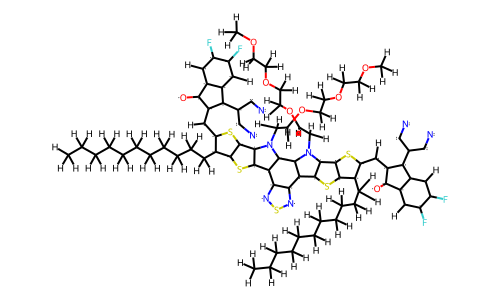

In [4]:
comp = Molecule.from_file("/home/madilyn/Projects/repos/forcefields/bto/bto.sdf",file_format = "sdf")
comp.visualize()

Done!


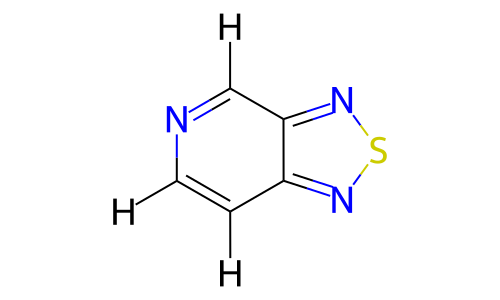

In [6]:
b= BondWalker(Molecule.from_file("/home/madilyn/Projects/repos/forcefields/PT/pt.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

In [7]:
#Change input file for molecule
#This one needs to be .sdf file!

molecule = compound

molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]

AttributeError: module 'dgl' has no attribute 'to_homo'

In [ ]:
# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)

In [ ]:
# step 1: how to get bond parameters

bond_parameters = {}

for bond in structure.bonds:
    bond_parameters[(bond.atom1.name, bond.atom2.name)] = {"k":[bond.type.k] , "l0":[bond.type.req]}
    
# step 2: get angle parameters

angle_parameters = {}

for angle in structure.angles:
    angle_parameters[(angle.atom1.name, angle.atom2.name,angle.atom3.name)] = {"k":[angle.type.k], 
                                                                               "t0":[angle.type.theteq]}
    
# step 3: dihedral parameters

dihedral_parameters = {}

for dihedral in structure.dihedrals:
    dihedral_parameters[(dihedral.atom1.name, dihedral.atom2.name,dihedral.atom3.name,
                         dihedral.atom4.name)] = {"periodicity":[dihedral.type.per],
                                                  "k":[dihedral.type.phi_k],"phase":[dihedral.type.phase]}
    
# step 4: non-bonding parameters

nonbonded_parameters = {}

for nonbonded in structure.adjusts:
    nonbonded_parameters[(nonbonded.atom1.name,nonbonded.atom2.name)] = {"sigma":[nonbonded.type.rmin],
                                                    "epsilon":[nonbonded.type.epsilon],
                                                    "charge":[nonbonded.type.chgscale]}

In [ ]:
for i in range(len(compound.atoms)):
    if compound.atoms[i].atomic_number == 6:
        compound.atoms[i].name = 'C'
    if compound.atoms[i].atomic_number == 1:
        compound.atoms[i].name = 'H'
    if compound.atoms[i].atomic_number == 7:
        compound.atoms[i].name = 'N'
    if compound.atoms[i].atomic_number == 16:
        compound.atoms[i].name = 'S'
    if compound.atoms[i].atomic_number == 8:
        compound.atoms[i].name = 'O'
    #print(compound.atoms[i].name)

In [5]:
particle_types = []
type_map = dict()

for i in range(pair_forces.getNumParticles()):
    pair_parms = pair_forces.getParticleParameters(index=i)
    charge = pair_parms[0]
    sigma = pair_parms[1]
    epsilon = pair_parms[2]
    if (charge, sigma, epsilon) not in particle_types: 
        particle_types.append((charge, sigma, epsilon))

    type_map[compound.atoms[i].molecule_atom_index] = "".join([compound.atoms[i].name , str(particle_types.index((charge, sigma, epsilon)))])

print(type_map)

NameError: name 'pair_forces' is not defined

In [ ]:
#""" type map is where our error is coming from """
#
#
#import networkx  as nx
#Gopenmm = nx.Graph()
#Gparmed = nx.Graph()
##openmm:
#for i in range(bond_forces.getNumBonds()):
#    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
##parmed
#for b in structure.bonds:
#    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
#type_map = {}
##nx.rooted_tree_isomorphism
##in here we still need to check that one known index on one corresponds to the same index on the other....
#tree_openmm = nx.bfs_tree(Gopenmm,0)
#tree_parmed = nx.bfs_tree(Gparmed,0)
#if nx.is_isomorphic(Gopenmm,Gparmed):
##if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
#    for b in structure.bonds:
#        type_map[b.atom1.idx] = b.atom1.atom_type.__str__()
#        type_map[b.atom2.idx] = b.atom2.atom_type.__str__()
#print(type_map)

In [ ]:
# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

CPDT = mb.load("/home/madilyn/Projects/repos/forcefields/CPDT.mol2")

for index in type_map:
    CPDT[index].name = type_map[index]

In [ ]:
bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
print(bond_dict)

In [ ]:
angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
print(angle_dict)

In [ ]:
dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        #print(dt,periodicity,phase)
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
print(dihedral_dict)

In [ ]:
nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #if (charge,sigma,epsilon) not in nonbonded_types:
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
print(nonbonded_dict)

In [ ]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="CPDT.xml", #change this to whatever you want to save your xml file as
    compound=CPDT,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
CPDT.save("/home/madilyn/Projects/repos/forcefields/CPDT_typed.mol2", overwrite=True) #change this to match your molecule name. 